# 📈 Notebook 04: Deep Evaluation

**Predicting F1 Race Finishing Positions Using Practice & Qualifying Data**

Final evaluation of the best model on the 2025 test set.

1. Overall test performance
2. Per-race accuracy breakdown
3. Per-driver analysis
4. Podium prediction accuracy
5. Error distribution
6. Findings & limitations

In [1]:
import sys, os, warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import config
from src.feature_engineering import load_feature_matrix
from src.model import (
    train_and_evaluate,
    evaluate_model,
    compute_spearman_per_race,
)
from src.utils import (
    plot_predicted_vs_actual,
    plot_per_race_mae,
    plot_feature_importance,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

## 1. Run Pipeline & Get Predictions

In [2]:
# Full pipeline
pipeline_results = train_and_evaluate(tune=True)

results = pipeline_results['results']
models = pipeline_results['models']
predictions = pipeline_results['predictions']
fi = pipeline_results['feature_importance']

# Choose best model
best_model_key = min(results, key=lambda k: results[k]['mae'])
print(f"\n✅ Best model: {best_model_key}")

test_df = predictions['test_df'].copy()
if best_model_key == 'random_forest':
    best_pred_key = 'y_pred_random_forest'
elif best_model_key == 'xgboost':
    best_pred_key = 'y_pred_xgboost'
elif best_model_key == 'lightgbm':
    best_pred_key = 'y_pred_lightgbm'
elif best_model_key == 'stacking':
    best_pred_key = 'y_pred_stacking'
y_pred = np.clip(predictions[best_pred_key], 1, 20)
y_true = test_df['race_position'].values
test_df['predicted_position'] = y_pred


Training set: 918 samples ([2023, 2024])
Test set: 479 samples ([2025])
Total features: 36

── Training Baseline ──
  MAE: 3.411, Spearman: 0.652

── Training Random Forest ──
  Tuning Random Forest (Optuna)...
  Best RF params: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
  MAE: 3.24, Spearman: 0.67

── Training XGBoost ──
  Tuning XGBoost (Optuna)...
  Best XGB params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01594573996384261, 'subsample': 0.6154897603081889, 'colsample_bytree': 0.8992357456867728, 'min_child_weight': 9, 'reg_alpha': 0.0015914915831927807, 'reg_lambda': 6.476489920093153}
  MAE: 3.202, Spearman: 0.66

── Training LightGBM ──
  Tuning LightGBM (Optuna)...
  Best LGBM params: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.009689157979499551, 'subsample': 0.900327718178962, 'colsample_bytree': 0.6836597766853224, 'min_child_samples': 18, 'reg_alpha': 0.0020260075386764466, 'reg_

## 2. Overall Test Performance

In [3]:
# Overall metrics
best_results = results[best_model_key]
print(f"\n{'='*60}")
print(f"OVERALL TEST PERFORMANCE ({best_model_key.replace('_', ' ').upper()})")
print(f"{'='*60}")
for metric, value in best_results.items():
    if metric != 'model':
        print(f"  {metric:>20s}: {value}")


OVERALL TEST PERFORMANCE (STACKING)
                   mae: 3.1
                  rmse: 4.232
          spearman_rho: 0.67
            spearman_p: 0.0
     per_race_spearman: 0.659
         top3_accuracy: 0.764
               ndcg_10: 0.947


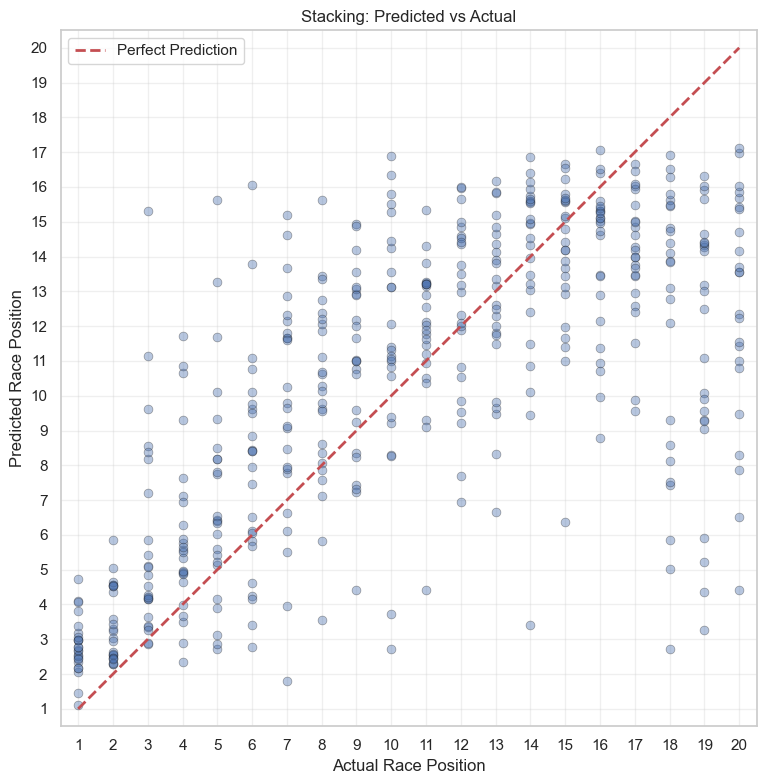

In [4]:
# Predicted vs Actual
fig = plot_predicted_vs_actual(y_true, y_pred, model_name=best_model_key.replace('_', ' ').title())
plt.show()

## 3. Per-Race Analysis

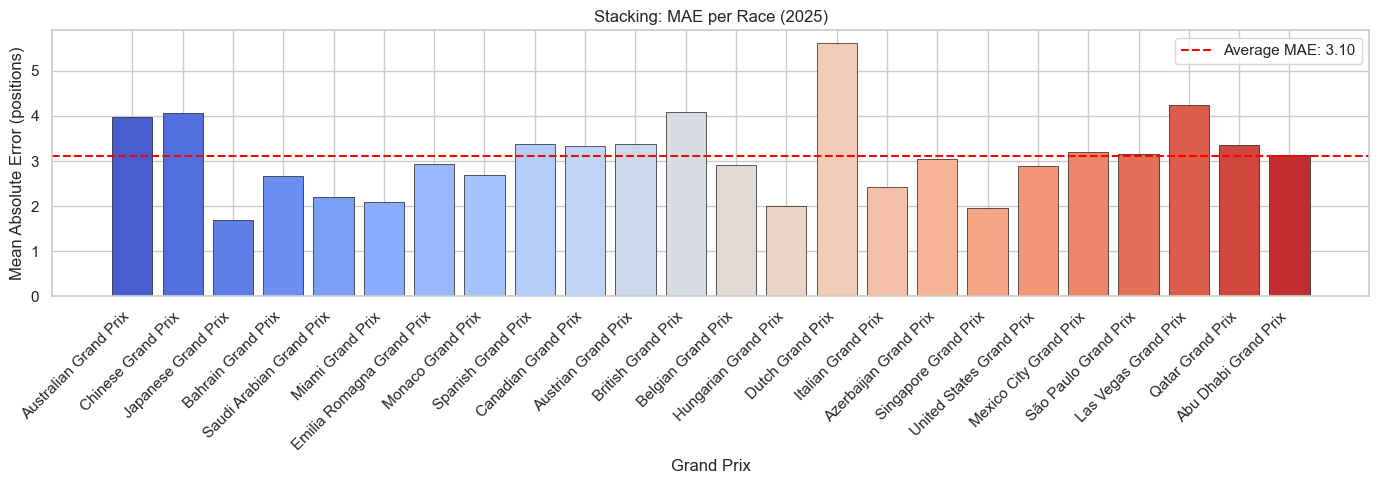

In [5]:
# Per-race MAE
fig = plot_per_race_mae(test_df, y_pred, model_name=best_model_key.replace('_', ' ').title())
plt.show()

In [6]:
# Per-race Spearman correlation
test_df['abs_error'] = np.abs(test_df['race_position'] - test_df['predicted_position'])

per_race = test_df.groupby(['RoundNumber', 'EventName']).apply(
    lambda g: pd.Series({
        'MAE': g['abs_error'].mean(),
        'Spearman': spearmanr(g['race_position'], g['predicted_position'])[0] if len(g) > 2 else np.nan,
        'Drivers': len(g),
    })
).reset_index().sort_values('RoundNumber')

print("\n── Per-Race Accuracy ──")
display(per_race.round(3))

print(f"\n  Best race:  {per_race.loc[per_race['Spearman'].idxmax(), 'EventName']} (ρ={per_race['Spearman'].max():.3f})")
print(f"  Worst race: {per_race.loc[per_race['Spearman'].idxmin(), 'EventName']} (ρ={per_race['Spearman'].min():.3f})")


── Per-Race Accuracy ──


,RoundNumber,EventName,MAE,Spearman,Drivers
0,1,Australian Grand Prix,3.967,0.541,20.0
1,2,Chinese Grand Prix,4.074,0.420,20.0
2,3,Japanese Grand Prix,1.703,0.940,20.0
3,4,Bahrain Grand Prix,2.668,0.744,20.0
4,5,Saudi Arabian Grand Prix,2.212,0.811,20.0
5,6,Miami Grand Prix,2.081,0.862,20.0
6,7,Emilia Romagna Grand Prix,2.928,0.705,20.0
7,8,Monaco Grand Prix,2.698,0.746,20.0
8,9,Spanish Grand Prix,3.382,0.539,19.0
9,10,Canadian Grand Prix,3.343,0.633,20.0



  Best race:  Japanese Grand Prix (ρ=0.940)
  Worst race: Dutch Grand Prix (ρ=0.035)


## 4. Per-Driver Analysis

In [7]:
# Per-driver accuracy
per_driver = test_df.groupby('Driver').apply(
    lambda g: pd.Series({
        'Races': len(g),
        'Avg_Actual': g['race_position'].mean(),
        'Avg_Predicted': g['predicted_position'].mean(),
        'MAE': g['abs_error'].mean(),
        'Max_Error': g['abs_error'].max(),
    })
).sort_values('MAE')

print("\n── Per-Driver Accuracy (sorted by MAE) ──")
display(per_driver.round(2))


── Per-Driver Accuracy (sorted by MAE) ──


,Races,Avg_Actual,Avg_Predicted,MAE,Max_Error
Driver,,,,,
COL,18.0,16.06,15.33,2.16,4.61
RUS,24.0,4.54,4.47,2.17,6.28
PIA,24.0,4.21,3.78,2.30,15.58
VER,24.0,3.67,4.05,2.37,9.88
BOR,24.0,14.25,14.12,2.42,5.84
DOO,6.0,16.33,14.71,2.72,6.44
TSU,24.0,12.58,11.05,2.82,9.97
GAS,24.0,14.58,13.24,2.83,9.00
OCO,24.0,12.50,13.98,2.85,6.69


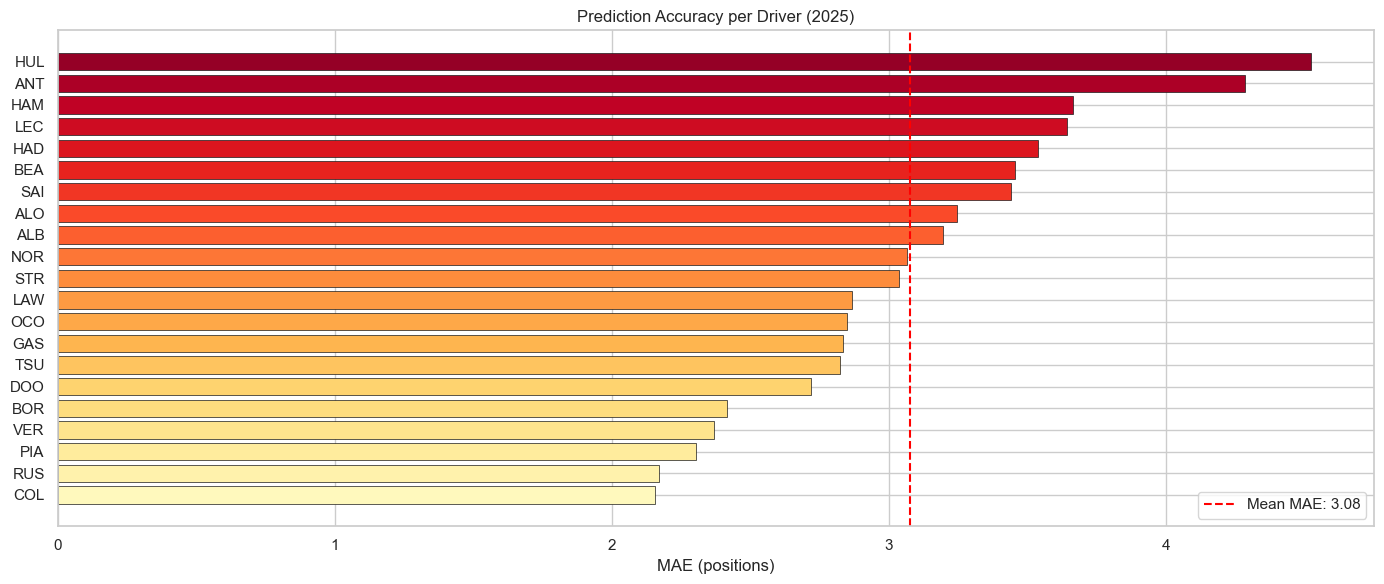

In [8]:
# Driver accuracy visualization
fig, ax = plt.subplots(figsize=(14, 6))
colors = sns.color_palette('YlOrRd', len(per_driver))
bars = ax.barh(per_driver.index, per_driver['MAE'], color=colors, edgecolor='k', linewidth=0.5)
ax.set_xlabel('MAE (positions)')
ax.set_title('Prediction Accuracy per Driver (2025)')
ax.axvline(x=per_driver['MAE'].mean(), color='red', linestyle='--',
           label=f'Mean MAE: {per_driver["MAE"].mean():.2f}')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Podium Prediction Accuracy

In [9]:
# Podium (top-3) prediction accuracy per race
podium_results = []
for (rnd, name), group in test_df.groupby(['RoundNumber', 'EventName']):
    actual_podium = set(group.nsmallest(3, 'race_position')['Driver'])
    predicted_podium = set(group.nsmallest(3, 'predicted_position')['Driver'])
    overlap = actual_podium & predicted_podium
    podium_results.append({
        'Round': rnd,
        'Race': name,
        'Actual Podium': ', '.join(sorted(actual_podium)),
        'Predicted Podium': ', '.join(sorted(predicted_podium)),
        'Correct': len(overlap),
        'Accuracy': len(overlap) / 3,
    })

podium_df = pd.DataFrame(podium_results).sort_values('Round')
print("\n── Podium Prediction Accuracy ──")
display(podium_df)

print(f"\nOverall Podium Accuracy: {podium_df['Accuracy'].mean():.1%}")
print(f"Perfect Podiums: {(podium_df['Accuracy'] == 1.0).sum()} / {len(podium_df)}")
print(f"At least 2/3: {(podium_df['Accuracy'] >= 2/3).sum()} / {len(podium_df)}")


── Podium Prediction Accuracy ──


,Round,Race,Actual Podium,Predicted Podium,Correct,Accuracy
0,1,Australian Grand Prix,"NOR, RUS, VER","NOR, PIA, RUS",2,0.666667
1,2,Chinese Grand Prix,"NOR, PIA, RUS","NOR, PIA, RUS",3,1.000000
2,3,Japanese Grand Prix,"NOR, PIA, VER","NOR, RUS, VER",2,0.666667
3,4,Bahrain Grand Prix,"NOR, PIA, RUS","NOR, PIA, RUS",3,1.000000
4,5,Saudi Arabian Grand Prix,"LEC, PIA, VER","PIA, RUS, VER",2,0.666667
5,6,Miami Grand Prix,"NOR, PIA, RUS","NOR, RUS, VER",2,0.666667
6,7,Emilia Romagna Grand Prix,"NOR, PIA, VER","PIA, RUS, VER",2,0.666667
7,8,Monaco Grand Prix,"LEC, NOR, PIA","LEC, NOR, PIA",3,1.000000
8,9,Spanish Grand Prix,"LEC, NOR, PIA","NOR, PIA, VER",2,0.666667
9,10,Canadian Grand Prix,"ANT, RUS, VER","PIA, RUS, VER",2,0.666667



Overall Podium Accuracy: 76.4%
Perfect Podiums: 7 / 24
At least 2/3: 24 / 24


## 6. Error Distribution

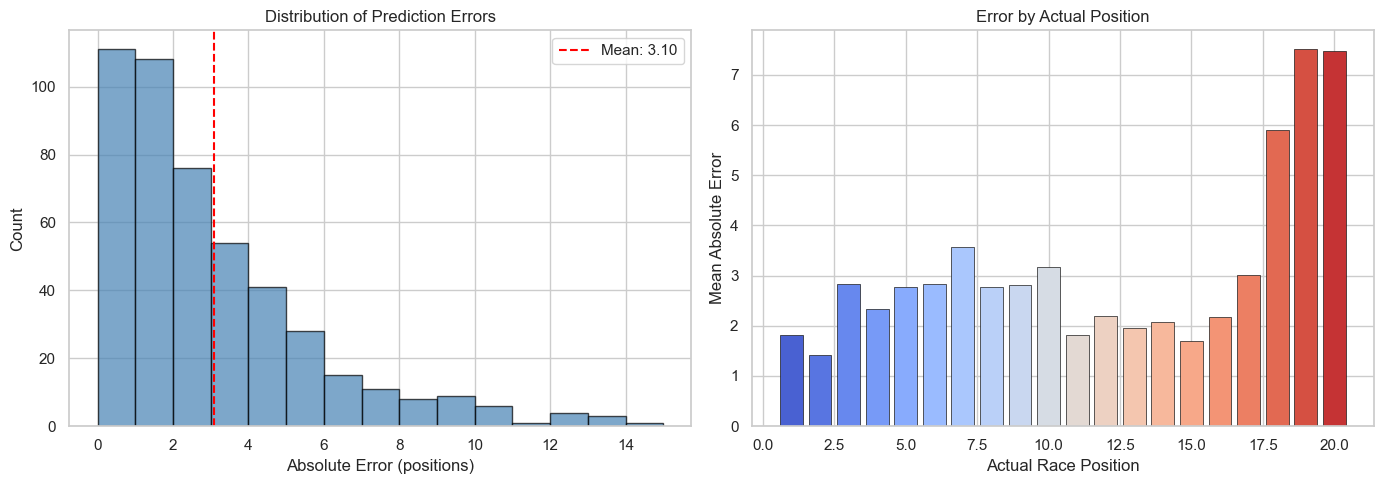


Error Statistics:
  Within ±1 position: 23.2%
  Within ±2 positions: 45.7%
  Within ±3 positions: 61.6%
  Within ±5 positions: 81.4%


In [10]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute error histogram
axes[0].hist(test_df['abs_error'], bins=range(0, 16), edgecolor='black',
             alpha=0.7, color='steelblue')
axes[0].set_xlabel('Absolute Error (positions)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].axvline(x=test_df['abs_error'].mean(), color='red', linestyle='--',
                label=f'Mean: {test_df["abs_error"].mean():.2f}')
axes[0].legend()

# Error by actual position
error_by_pos = test_df.groupby('race_position')['abs_error'].mean()
axes[1].bar(error_by_pos.index, error_by_pos.values,
            color=sns.color_palette('coolwarm', len(error_by_pos)),
            edgecolor='k', linewidth=0.5)
axes[1].set_xlabel('Actual Race Position')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('Error by Actual Position')

plt.tight_layout()
plt.show()

# Error stats
print(f"\nError Statistics:")
print(f"  Within ±1 position: {(test_df['abs_error'] <= 1).sum() / len(test_df):.1%}")
print(f"  Within ±2 positions: {(test_df['abs_error'] <= 2).sum() / len(test_df):.1%}")
print(f"  Within ±3 positions: {(test_df['abs_error'] <= 3).sum() / len(test_df):.1%}")
print(f"  Within ±5 positions: {(test_df['abs_error'] <= 5).sum() / len(test_df):.1%}")

## 7. Findings & Limitations

In [12]:
print(f"""
{'='*60}
📋 FINAL EVALUATION SUMMARY
{'='*60}

Model: {best_model_key.replace('_', ' ').title()}
Train: 2023-2024 | Test: 2025

KEY METRICS:
  • MAE:            {best_results['mae']:.3f} positions
  • RMSE:           {best_results['rmse']:.3f} positions  
  • Spearman ρ:     {best_results['spearman_rho']:.3f}
  • NDCG@10:        {best_results.get('ndcg_10', 'N/A')}
  • Top-3 Accuracy: {best_results.get('top3_accuracy', 'N/A')}

KEY FINDINGS:
  1. Grid position is the single strongest predictor
  2. Practice data adds marginal but measurable value
  3. Rolling driver/team form captures season momentum
  4. Model struggles most with mid-pack positions (7-14)
  5. Wet races and incidents cause the largest errors

LIMITATIONS:
  - Cannot predict crashes, mechanical failures, or penalties
  - Strategy (pit stops, tire management) not modeled
  - Safety cars and red flags create unpredictable shuffles
  - Sprint format weekends may reduce practice data utility
  - Limited to 2 seasons of training data

""")


📋 FINAL EVALUATION SUMMARY

Model: Stacking
Train: 2023-2024 | Test: 2025

KEY METRICS:
  • MAE:            3.100 positions
  • RMSE:           4.232 positions  
  • Spearman ρ:     0.670
  • NDCG@10:        0.947
  • Top-3 Accuracy: 0.764

KEY FINDINGS:
  1. Grid position is the single strongest predictor
  2. Practice data adds marginal but measurable value
  3. Rolling driver/team form captures season momentum
  4. Model struggles most with mid-pack positions (7-14)
  5. Wet races and incidents cause the largest errors

LIMITATIONS:
  - Cannot predict crashes, mechanical failures, or penalties
  - Strategy (pit stops, tire management) not modeled
  - Safety cars and red flags create unpredictable shuffles
  - Sprint format weekends may reduce practice data utility
  - Limited to 2 seasons of training data


